In [2]:
import torch 
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np

In [23]:
root="/r/scratch/users/mschillinger/data/cordexbench/"
domain="SA"
training_experiment = 'Emulator_hist_future'
mode = "train" 
if mode == "train":
    folder = "train"
else:
    raise ValueError("In DownscalingDatasetNormed: mode not recognised")
        
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ' or domain == 'SA':
    gcm_name = 'ACCESS-CM2'
DATA_PATH = root + f"/{domain}/{domain}_domain"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'

In [31]:
lr_path = f'{DATA_PATH}/{folder}/{training_experiment}/predictors/{gcm_name}_{period_training}.nc'
lr_ds = xr.open_dataset(lr_path).astype("float32")
if "time_bnds" in lr_ds.data_vars:
    lr_ds = lr_ds.drop_vars("time_bnds")
lr_ds

<xarray.Dataset> Size: 224MB
Dimensions:  (time: 14600, lat: 16, lon: 16)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31T1...
  * lon      (lon) float64 128B 11.0 13.0 15.0 17.0 19.0 ... 35.0 37.0 39.0 41.0
  * lat      (lat) float64 128B -40.0 -38.0 -36.0 -34.0 ... -14.0 -12.0 -10.0
Data variables: (12/15)
    t_500    (time, lat, lon) float32 15MB 259.6 260.2 260.9 ... 273.8 273.9
    t_700    (time, lat, lon) float32 15MB 273.9 275.0 276.7 ... 288.7 288.9
    t_850    (time, lat, lon) float32 15MB 281.1 281.9 283.3 ... 295.2 295.6
    u_500    (time, lat, lon) float32 15MB 32.73 31.41 29.55 ... -2.396 -1.73
    u_700    (time, lat, lon) float32 15MB 17.41 18.26 18.15 ... -2.398 -2.568
    u_850    (time, lat, lon) float32 15MB 8.384 7.54 8.119 ... -4.615 -4.077
    ...       ...
    z_500    (time, lat, lon) float32 15MB 5.658e+03 5.676e+03 ... 5.993e+03
    z_700    (time, lat, lon) float32 15MB 3.024e+03 3.033e+03 ... 3.214e+03
    z_850    (time, lat, lon) float32 15MB 1.443e+03 1.447e+03 ... 1.543e+03
    q_500    (time, lat, lon) float32 15MB 0.0007726 0.000761 ... 0.003252
    q_700    (time, lat, lon) float32 15MB 0.002427 0.00215 ... 0.007682 0.00525
    q_850    (time, lat, lon) float32 15MB 0.005501 0.005668 ... 0.0152 0.01188
Attributes: (12/259)
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    history:              Thu Sep 25 10:06:19 2025: cdo mergetime 2deg_ccam_a...
    source:               CSIRO conformal-cubic model. Input file: ccam_8.km....
    Conventions:          CF-1.11
    title:                CCAM simulation data
    il:                   192
    ...                   ...
    ateb_ac_deltat:       1.0
    ateb_ac_heatcap:      10.0
    ateb_acfactor:        2.0
    ateb_alpha:           1.0
    ateb_lwintmeth:       2
    ateb_cvcoeffmeth:     1

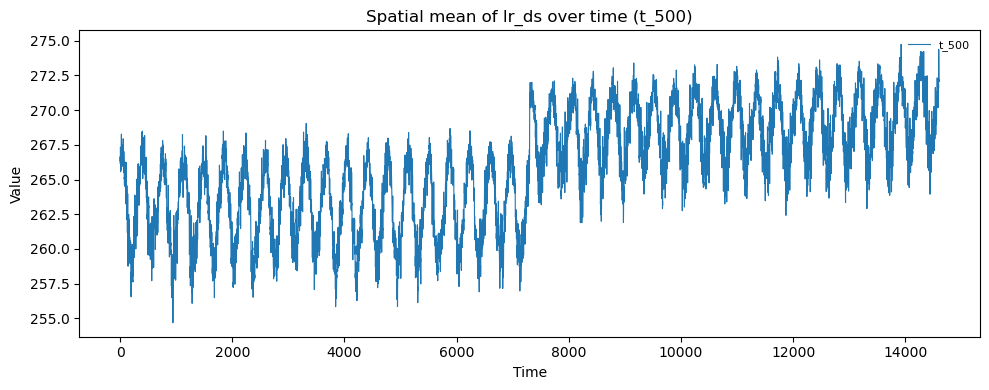

In [32]:
# spatial mean over lat/lon for each variable and plot over time
lr_mean = lr_ds.to_array().mean(dim=("lat", "lon"))
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(np.arange(len(lr_mean["time"])), lr_mean.sel(variable="t_500").values, label="t_500", lw=0.8)
ax.set_title("Spatial mean of lr_ds over time (t_500)")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend(loc="upper right", fontsize=8, frameon=False)
plt.tight_layout()

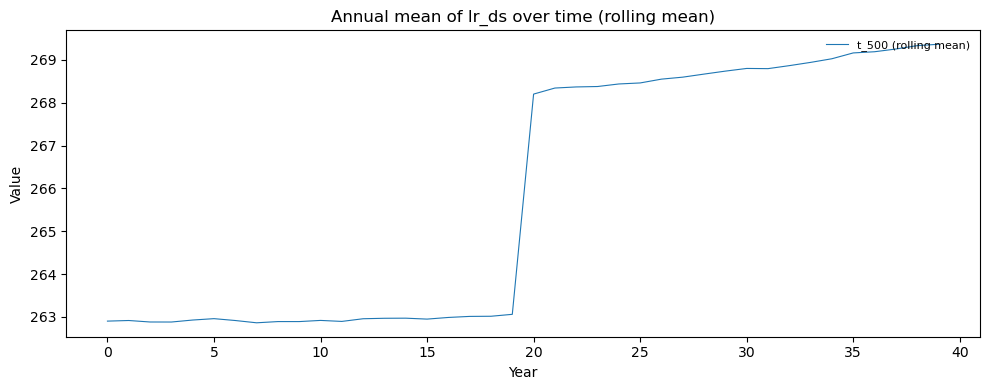

In [33]:
# spatial mean over lat/lon for each variable and plot over time
lr_mean = lr_ds.to_array().mean(dim=("lon", "lat"))
annual = lr_mean.groupby("time.year").mean("time")

window = 10
half = annual.sizes["year"] // 2
first = annual.isel(year=slice(0, half)).rolling(year=window, center=True, min_periods=1).mean()
second = annual.isel(year=slice(half, None)).rolling(year=window, center=True, min_periods=1).mean()
annual_smooth = xr.concat([first, second], dim="year")

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(annual_smooth.sel(variable="t_500").values, label="t_500 (rolling mean)", lw=0.8)
ax.set_title("Annual mean of lr_ds over time (rolling mean)")
ax.set_xlabel("Year")
ax.set_ylabel("Value")
ax.legend(loc="upper right", fontsize=8, frameon=False)
plt.tight_layout()

In [34]:
annual_smooth.sel(variable="t_500").values

array([262.90186, 262.9161 , 262.8814 , 262.88068, 262.92712, 262.95938,
       262.91586, 262.86264, 262.89105, 262.89105, 262.91815, 262.89487,
       262.9574 , 262.9682 , 262.9705 , 262.94885, 262.98746, 263.0119 ,
       263.01535, 263.06033, 268.20328, 268.34457, 268.37033, 268.38007,
       268.43958, 268.46347, 268.55246, 268.59875, 268.67026, 268.7397 ,
       268.80212, 268.7976 , 268.86755, 268.94357, 269.02863, 269.16446,
       269.1921 , 269.25568, 269.33438, 269.36685], dtype=float32)

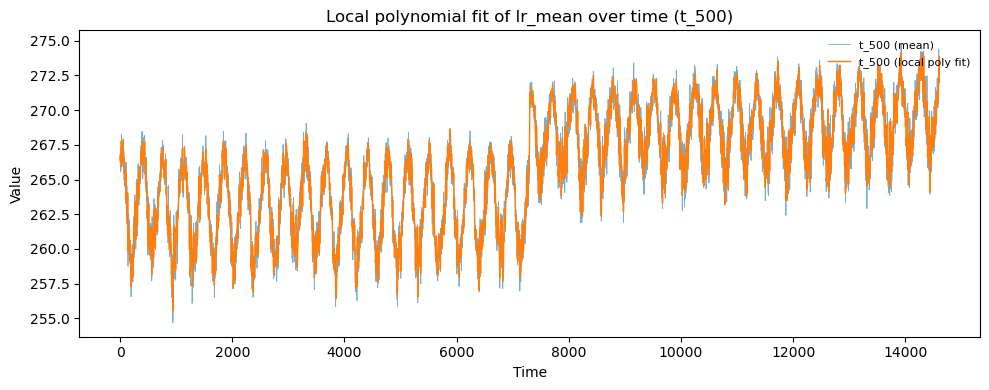

In [35]:
# local polynomial fit (rolling window) for t_500
series = lr_mean.sel(variable="t_500").values
t = np.arange(series.size)

half = window // 2
pred = np.full(series.shape, np.nan, dtype=float)
# Fit first half
for i in range(half):
    start = max(0, i - half)
    end = min(series.size, i + half + 1)
    coeffs = np.polyfit(t[start:end], series[start:end], deg=2)
    pred[i] = np.polyval(coeffs, t[i])

# Fit second half
for i in range(half, series.size):
    start = max(0, i - half)
    end = min(series.size, i + half + 1)
    coeffs = np.polyfit(t[start:end], series[start:end], deg=2)
    pred[i] = np.polyval(coeffs, t[i])

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t, series, label="t_500 (mean)", lw=0.6, alpha=0.6)
ax.plot(t, pred, label="t_500 (local poly fit)", lw=1.0)
ax.set_title("Local polynomial fit of lr_mean over time (t_500)")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend(loc="upper right", fontsize=8, frameon=False)
plt.tight_layout()

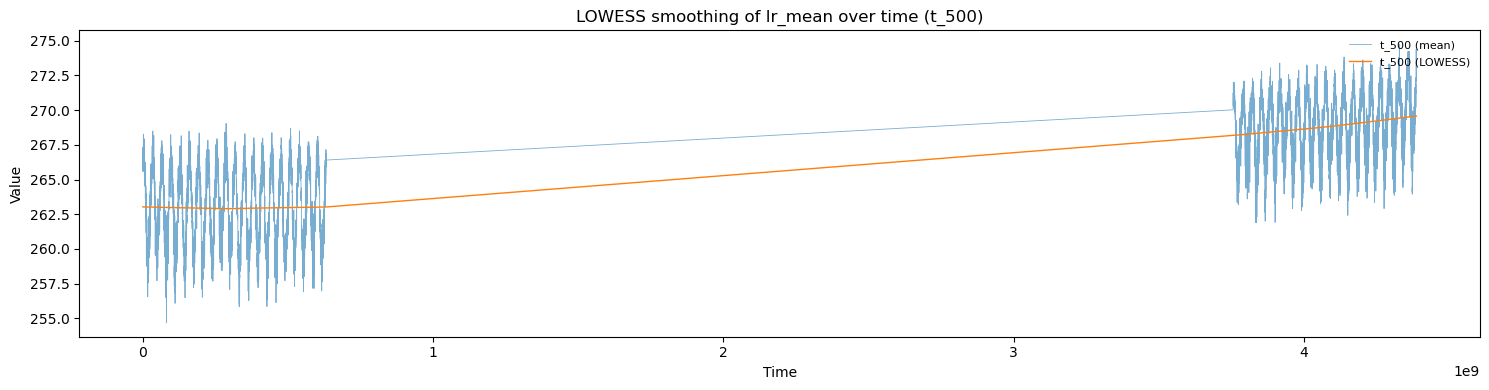

In [36]:
from statsmodels.nonparametric.smoothers_lowess import lowess

series = lr_mean.sel(variable="t_500").values
window = 20*365
t = (lr_mean.time - lr_mean.time[0]).astype("timedelta64[D]").astype(float)
pred = lowess(
    series,
    t,
    frac=window / series.size,   # roughly comparable to your window
    it=0,                         # no robust iterations
    return_sorted=False
)

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(t, series, label="t_500 (mean)", lw=0.6, alpha=0.6)
ax.plot(t, pred, label="t_500 (LOWESS)", lw=1.0)
ax.set_title("LOWESS smoothing of lr_mean over time (t_500)")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend(loc="upper right", fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

In [37]:
pred

array([263.0304446 , 263.0303969 , 263.03034922, ..., 269.57874714,
       269.57898486, 269.5792226 ], shape=(14600,))

In [38]:
name_str = ""
data_type = "tasmax"
file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"
save_path = os.path.join(root, domain, "norm_stats", f"hr_norm_stats_forcing-proxy_{file_base}.pt")
save_path

'/r/scratch/users/mschillinger/data/cordexbench/SA/norm_stats/hr_norm_stats_forcing-proxy_Emulator_hist_future_tasmax_ACCESS-CM2_1961-1980_2080-2099.pt'

In [39]:
np.save(save_path, pred)

In [40]:
x = xr.DataArray(pred, dims="time", coords={"time": lr_ds.time})

In [41]:
from sklearn.linear_model import LinearRegression
pred_anomaly = pred - pred[0]
x = xr.DataArray(pred_anomaly, dims="time", coords={"time": lr_ds.time})
def fit_lin_sklearn(y):
    model = LinearRegression()
    X = x.values.reshape(-1, 1)
    Y = y.values.reshape(X.shape[0], -1)
    model.fit(X, Y)
    slope = model.coef_[:, 0]
    intercept = model.intercept_
    linear_pred = model.predict(X).reshape(y.shape)
    detrended_y = y - linear_pred + intercept.reshape(y.shape[1:])
    return {
        "slope": slope.reshape(y.shape[1:]),
        "intercept": intercept.reshape(y.shape[1:]),
        "detrended": detrended_y,
        "pred": linear_pred
    }

result = {
    var: fit_lin_sklearn(lr_ds[var])
    for var in lr_ds.data_vars
}

In [42]:
result["t_500"]["slope"]

array([[0.94312624, 0.94516265, 0.94786555, 0.94995954, 0.95111389,
        0.95290029, 0.95240984, 0.94976575, 0.94589998, 0.94070398,
        0.93575344, 0.92917007, 0.92319714, 0.91971414, 0.91628732,
        0.91529749],
       [0.96207764, 0.96662112, 0.97218157, 0.9759978 , 0.97774619,
        0.97802842, 0.97612057, 0.97218367, 0.96676592, 0.95920237,
        0.95204927, 0.94496714, 0.93952557, 0.93592021, 0.93260252,
        0.93151087],
       [1.00199965, 1.00927817, 1.01669903, 1.02092848, 1.02267458,
        1.01984471, 1.01490161, 1.00746587, 0.99745883, 0.98659482,
        0.97679738, 0.96858768, 0.96225185, 0.95699582, 0.95395133,
        0.95274386],
       [1.05287819, 1.05985329, 1.06652959, 1.06993313, 1.06967215,
        1.06342593, 1.05427143, 1.04095805, 1.02614565, 1.01244233,
        1.0011603 , 0.99150168, 0.98283053, 0.97780936, 0.97585601,
        0.97437567],
       [1.10170204, 1.10741892, 1.11195711, 1.11161098, 1.10562937,
        1.09292987, 1.0764955 , 

In [43]:
result["t_500"]["detrended"]

<xarray.DataArray 't_500' (time: 14600, lat: 16, lon: 16)> Size: 30MB
array([[[259.61364746, 260.21188354, 260.93890381, ..., 263.02307129,
         262.6831665 , 262.44927979],
        [261.2538147 , 261.72616577, 262.34649658, ..., 263.2116394 ,
         262.77401733, 262.54611206],
        [262.93011475, 263.28573608, 263.69924927, ..., 263.29614258,
         262.85284424, 262.68997192],
        ...,
        [268.43173218, 268.34359741, 268.44244385, ..., 268.54855347,
         268.25054932, 268.40615845],
        [268.52047729, 268.331604  , 268.05459595, ..., 268.24911499,
         268.12744141, 268.20809937],
        [268.58306885, 268.42944336, 268.12649536, ..., 268.01245117,
         267.95193481, 268.056427  ]],

       [[261.68836896, 261.85768058, 262.12351933, ..., 262.54713249,
         262.49613745, 262.49018648],
        [262.81507885, 263.02854952, 263.28358519, ..., 263.13404733,
         263.12742485, 262.99033984],
        [264.17833148, 264.25581596, 264.43501553, ..., 263.65852343,
         263.59828158, 263.6237637 ],
...
        [267.46682843, 267.60232704, 267.33767745, ..., 266.39182733,
         266.40844983, 266.96470757],
        [267.60227549, 267.67691328, 267.26839591, ..., 266.78799754,
         266.8743179 , 267.11072683],
        [268.0646988 , 267.73866517, 267.39593378, ..., 267.22670708,
         267.14398201, 267.70453502]],

       [[259.40869761, 259.21359891, 259.03873271, ..., 259.49686324,
         259.69963309, 260.21728471],
        [260.19514206, 260.18681117, 260.1340091 , ..., 261.32090907,
         261.63792397, 261.54180145],
        [261.6638042 , 261.7482494 , 261.87442601, ..., 263.08584367,
         262.95499401, 263.06898057],
        ...,
        [267.89440367, 267.85876041, 267.58575102, ..., 266.55617205,
         266.49985628, 266.83248172],
        [268.1647727 , 268.10098378, 267.76979738, ..., 266.97859142,
         267.19271862, 267.42125432],
        [268.28811767, 268.19258432, 267.887663  , ..., 267.13874025,
         267.44221405, 267.58498176]]], shape=(14600, 16, 16))
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31T1...
  * lon      (lon) float64 128B 11.0 13.0 15.0 17.0 19.0 ... 35.0 37.0 39.0 41.0
  * lat      (lat) float64 128B -40.0 -38.0 -36.0 -34.0 ... -14.0 -12.0 -10.0

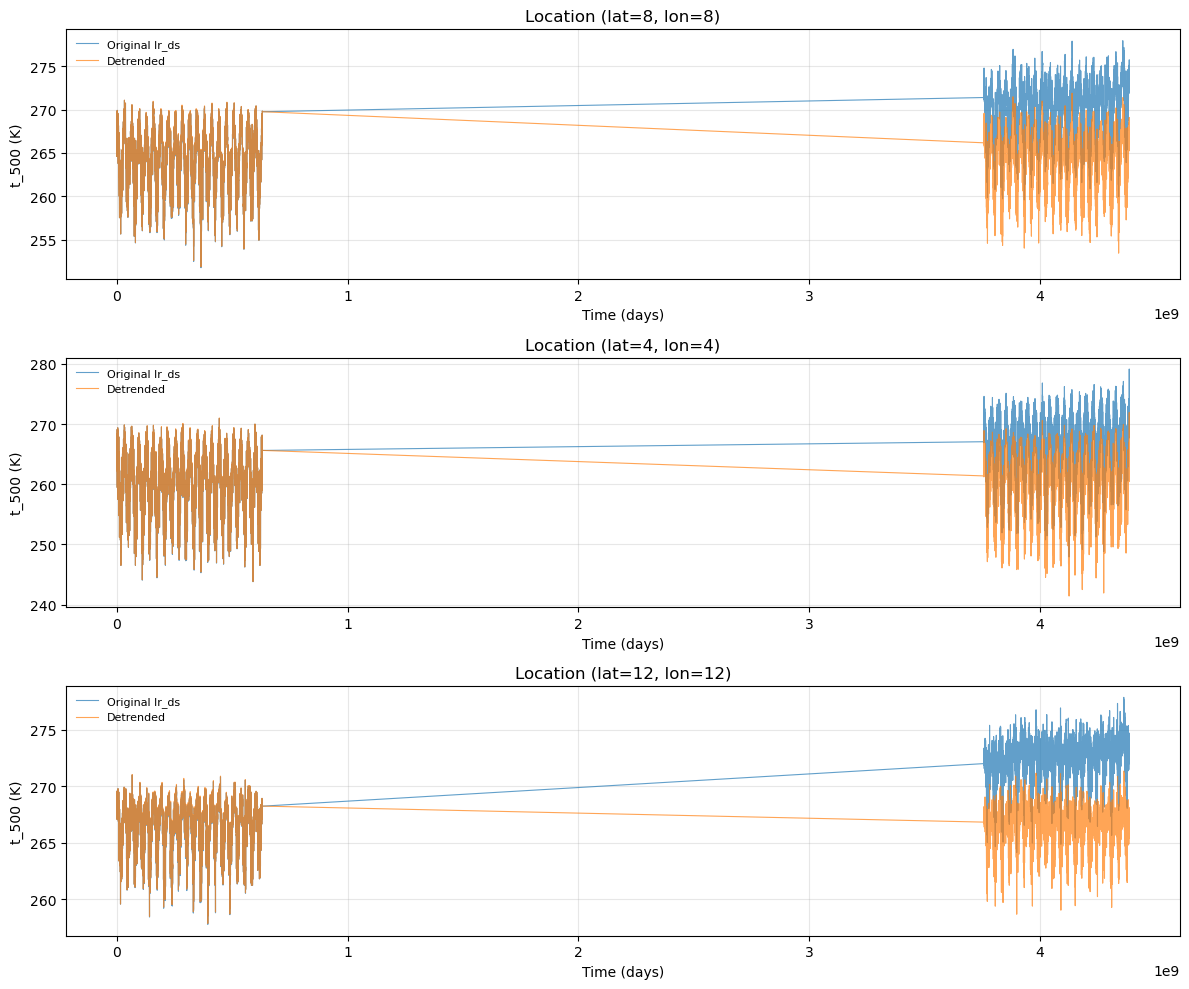

In [44]:
# Select a few spatial locations and plot original vs detrended data
locations = [(8, 8), (4, 4), (12, 12)]  # (lat_idx, lon_idx)
fig, axes = plt.subplots(len(locations), 1, figsize=(12, 10))

for idx, (lat_idx, lon_idx) in enumerate(locations):
    ax = axes[idx]
    
    # Original lr_ds t_500
    original = lr_ds['t_500'].isel(lat=lat_idx, lon=lon_idx).values
    
    # Detrended prediction from result
    detrended = result['t_500']['detrended'].isel(lat=lat_idx, lon=lon_idx).values
    
    ax.plot(t.values, original, label='Original lr_ds', lw=0.8, alpha=0.7)
    ax.plot(t.values, detrended, label='Detrended', lw=0.8, alpha=0.7)
    ax.set_title(f'Location (lat={lat_idx}, lon={lon_idx})')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('t_500 (K)')
    ax.legend(fontsize=8, frameon=False)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

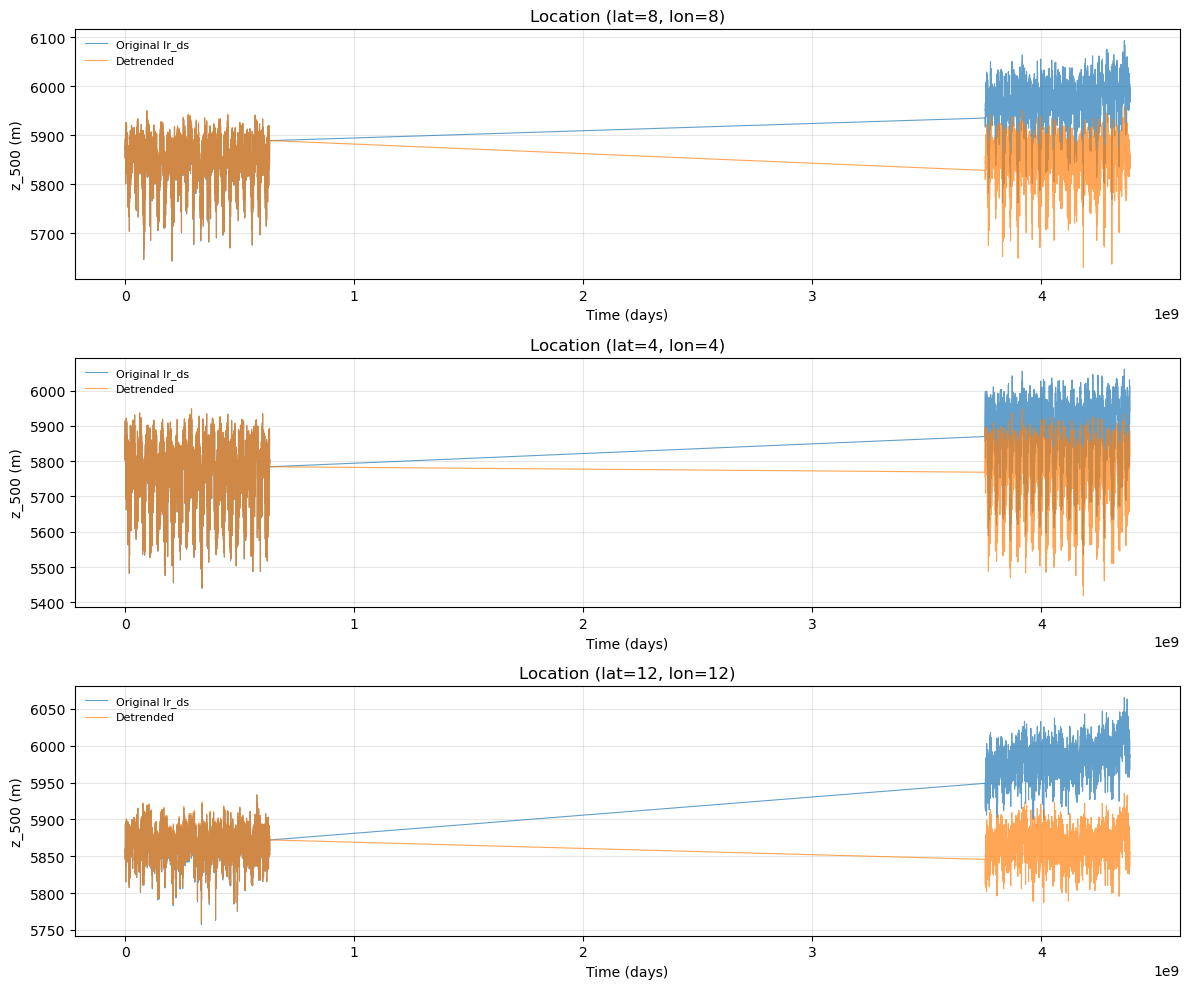

In [45]:
# Select a few spatial locations and plot original vs detrended data
locations = [(8, 8), (4, 4), (12, 12)]  # (lat_idx, lon_idx)
fig, axes = plt.subplots(len(locations), 1, figsize=(12, 10))

for idx, (lat_idx, lon_idx) in enumerate(locations):
    ax = axes[idx]
    
    # Original lr_ds t_500
    original = lr_ds['z_500'].isel(lat=lat_idx, lon=lon_idx).values
    
    # Detrended prediction from result
    detrended = result['z_500']['detrended'].isel(lat=lat_idx, lon=lon_idx).values
    
    ax.plot(t.values, original, label='Original lr_ds', lw=0.8, alpha=0.7)
    ax.plot(t.values, detrended, label='Detrended', lw=0.8, alpha=0.7)
    ax.set_title(f'Location (lat={lat_idx}, lon={lon_idx})')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('z_500 (m)')
    ax.legend(fontsize=8, frameon=False)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

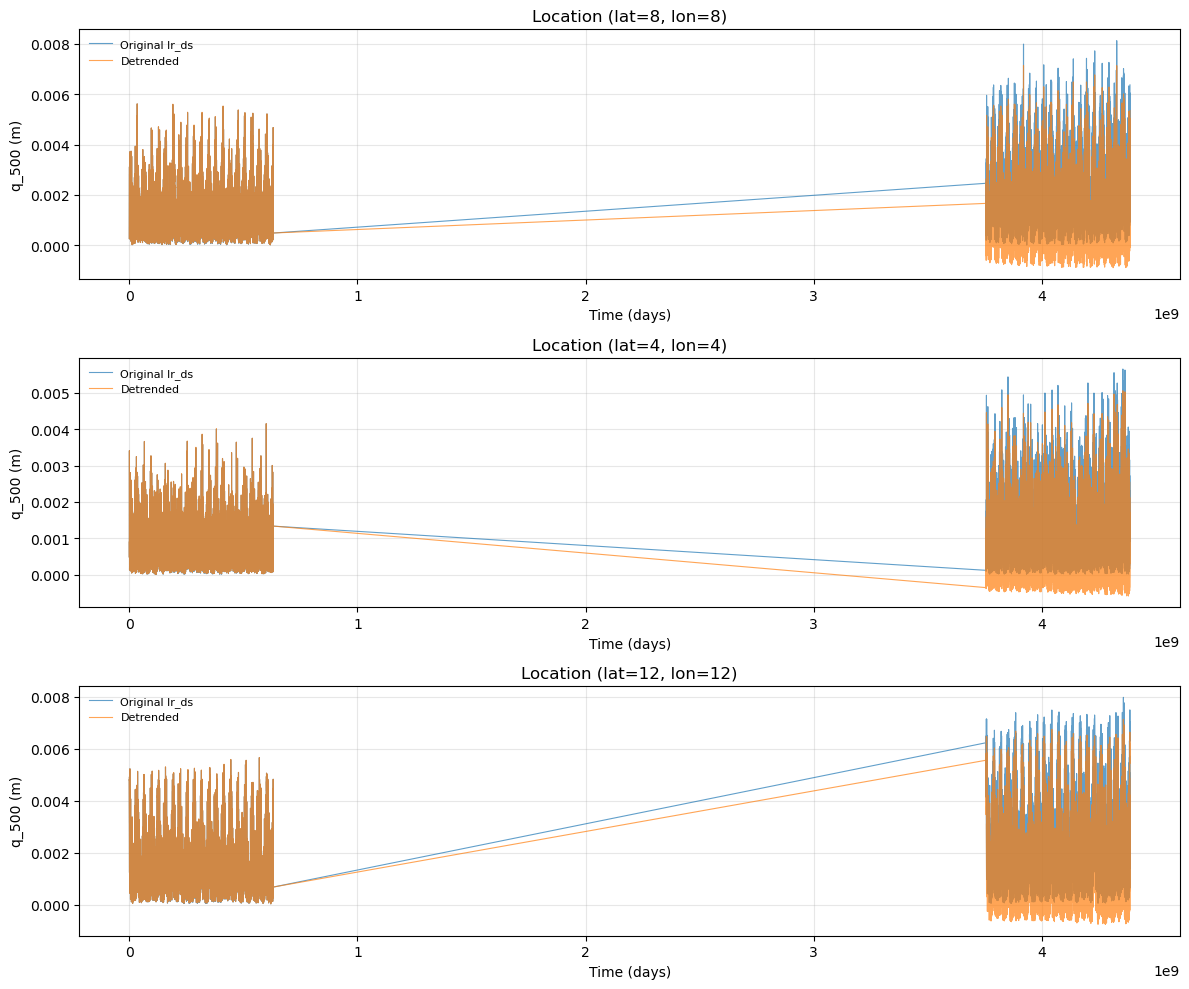

In [46]:
# Select a few spatial locations and plot original vs detrended data
locations = [(8, 8), (4, 4), (12, 12)]  # (lat_idx, lon_idx)
fig, axes = plt.subplots(len(locations), 1, figsize=(12, 10))

for idx, (lat_idx, lon_idx) in enumerate(locations):
    ax = axes[idx]
    
    # Original lr_ds t_500
    original = lr_ds['q_500'].isel(lat=lat_idx, lon=lon_idx).values
    
    # Detrended prediction from result
    detrended = result['q_500']['detrended'].isel(lat=lat_idx, lon=lon_idx).values
    
    ax.plot(t.values, original, label='Original lr_ds', lw=0.8, alpha=0.7)
    ax.plot(t.values, detrended, label='Detrended', lw=0.8, alpha=0.7)
    ax.set_title(f'Location (lat={lat_idx}, lon={lon_idx})')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('q_500 (m)')
    ax.legend(fontsize=8, frameon=False)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
only_detrended = xr.Dataset({
    var: result[var]['detrended']
    for var in lr_ds.data_vars
})

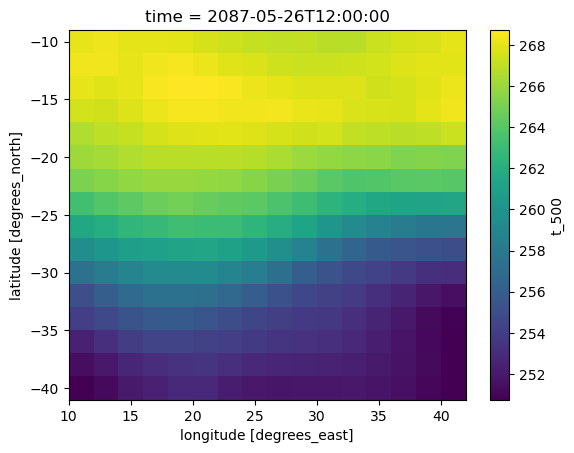

In [48]:
only_detrended["t_500"][10000].plot()

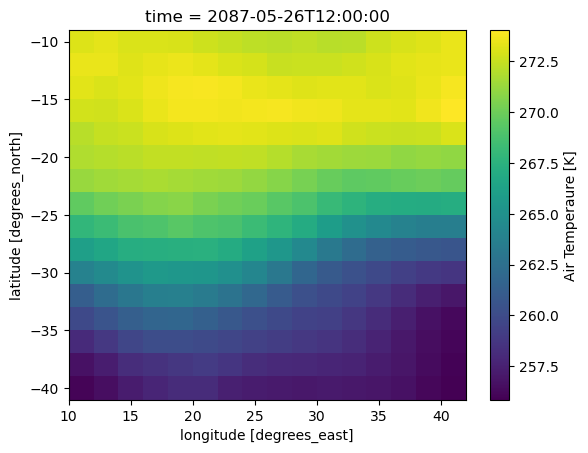

In [49]:
lr_ds["t_500"][10000].plot()

In [50]:
only_detrended.to_netcdf(f'{root}/{domain}/norm_stats/{training_experiment}_{gcm_name}_{period_training}_climate-change-lin-detrended.nc')